### Mnist分类任务：

- 网络基本构建与训练方法，常用函数解析

- torch.nn.functional模块

- nn.Module模块


### 读取Mnist数据集
- 会自动进行下载

In [17]:
%matplotlib inline

In [18]:
from pathlib import Path

import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [19]:
import gzip
import pickle

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

784是mnist数据集每个样本的像素点个数

(50000, 784)


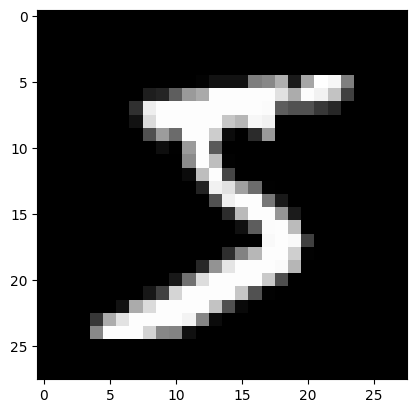

In [20]:
import numpy as np
from matplotlib import pyplot

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

<img src="./img/4.png" alt="FAO" width="790">

<img src="./img/5.png" alt="FAO" width="790">

注意数据需转换成tensor才能参与后续建模训练


In [21]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### torch.nn.functional 很多层和函数在这里都会见到

torch.nn.functional中有很多功能，后续会常用的。那什么时候使用nn.Module，什么时候使用nn.functional呢？一般情况下，如果模型有可学习的参数，最好用nn.Module，其他情况nn.functional相对更简单一些

In [22]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb.mm(weights) + bias

In [39]:
bs = 64
xb = x_train[0:bs]  # a mini-batch from x
yb = y_train[0:bs]
weights = torch.randn([784, 10], dtype = torch.float,  requires_grad = True) 
bs = 64
bias = torch.zeros(10, requires_grad=True)

loss = loss_func(model(xb), yb)
print(loss)
loss.item()
len(xb)

tensor(2.3069, grad_fn=<NllLossBackward0>)


64

### 创建一个model来更简化代码

- 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [24]:
from torch import nn


class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128) # 全连接
        self.hidden2 = nn.Linear(128, 256)
        self.out  = nn.Linear(256, 10)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.dropout(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x
        

In [25]:
net = Mnist_NN()
print(net)


Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


可以打印我们定义好名字里的权重和偏置项

In [26]:
# w会自动初始化
for name, parameter in net.named_parameters():
    print(name, parameter,parameter.size())

hidden1.weight Parameter containing:
tensor([[-0.0269, -0.0072,  0.0072,  ..., -0.0298, -0.0283,  0.0178],
        [ 0.0127, -0.0267, -0.0127,  ...,  0.0166,  0.0328,  0.0189],
        [-0.0320, -0.0161, -0.0088,  ..., -0.0171,  0.0244,  0.0298],
        ...,
        [-0.0303, -0.0282,  0.0140,  ..., -0.0023, -0.0353,  0.0348],
        [ 0.0118, -0.0228,  0.0247,  ...,  0.0241,  0.0109, -0.0048],
        [-0.0057, -0.0155,  0.0307,  ..., -0.0350, -0.0062,  0.0067]],
       requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([ 0.0289,  0.0242,  0.0357,  0.0010,  0.0201,  0.0308, -0.0287, -0.0219,
        -0.0351, -0.0316, -0.0314, -0.0053, -0.0152,  0.0135, -0.0223,  0.0181,
         0.0252,  0.0050,  0.0091, -0.0300, -0.0326,  0.0126,  0.0126,  0.0175,
        -0.0111, -0.0032, -0.0118,  0.0021, -0.0333,  0.0148,  0.0205, -0.0214,
        -0.0067,  0.0247, -0.0207,  0.0305,  0.0298,  0.0237, -0.0268,  0.0234,
         0.0105, -0.0303,  0.0004,  0.0115, 

### 使用TensorDataset和DataLoader来简化

In [27]:
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(x_train, y_train)
# shuffle 每一个epoch打乱训练数据的顺序
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs)

In [28]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs),
    )

- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

In [29]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    # model(input) == model.forward(input)
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad() # torch会自动做梯度的累加，每次迭代前需要手动清0

    return loss.item(), len(xb)

In [30]:
import numpy as np


def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps): # epoch
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():# 验证模式不更新
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:'+str(step), '验证集损失：'+str(val_loss))

In [31]:
from torch import optim


def get_model():
    model = Mnist_NN()
    return model, optim.SGD(model.parameters(), lr=0.001)

### 三行搞定！

In [37]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
sample = iter(train_dl)
xb, yb = next(sample)

print(model(xb).shape)
yb.shape

torch.Size([64, 10])


torch.Size([64])

In [40]:
fit(25, model, loss_func, opt, train_dl, valid_dl)

当前step:0 验证集损失：2.2804833972930907
当前step:1 验证集损失：2.2525653312683107
当前step:2 验证集损失：2.21288744468689
当前step:3 验证集损失：2.1551383895874023
当前step:4 验证集损失：2.073294314956665
当前step:5 验证集损失：1.9595987125396728
当前step:6 验证集损失：1.8073242906570435
当前step:7 验证集损失：1.6179550661087037
当前step:8 验证集损失：1.4124386936187745
当前step:9 验证集损失：1.2263709316253661
当前step:10 验证集损失：1.0761143341064454
当前step:11 验证集损失：0.9598291326522828
当前step:12 验证集损失：0.8694684852600097
当前step:13 验证集损失：0.7978080226898193
当前step:14 验证集损失：0.740206939983368
当前step:15 验证集损失：0.6916911737442016
当前step:16 验证集损失：0.6521799218177795
当前step:17 验证集损失：0.6189346996307373
当前step:18 验证集损失：0.590044945716858
当前step:19 验证集损失：0.5658472233772278
当前step:20 验证集损失：0.5443763592243195
当前step:21 验证集损失：0.5247211284637451
当前step:22 验证集损失：0.5084267935276031
当前step:23 验证集损失：0.4925997139453888
当前step:24 验证集损失：0.4785043688774109


In [41]:
correct = 0
total = 0
for xb, yb in valid_dl:
    outputs = model(xb)
    _, predicted = torch.max(outputs.data, 1) # 最大值和索引
    total += yb.size(0)
    correct += (predicted == yb).sum().item()

print('Accuracy of the network: %d %%' % (100 * correct / total))

Accuracy of the network: 87 %
